# Importing Necessary Libraries

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,Subset,random_split
from torchvision import datasets,models
from torchvision import transforms as T
import torchvision.transforms.functional as TF
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time,random
from torchvision.transforms.functional import to_pil_image
from sklearn.manifold import TSNE
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Downloading the Dataset and Splitting into Train,Test & Unlabeled

In [5]:
# train_dataset = datasets.STL10(root='data/', split='train', download=True)
# test_dataset = datasets.STL10(root='data/', split='test', download=True)
# unlabeled = datasets.STL10(root='data/', split='unlabeled', download=True)
transform = T.Compose([T.Resize((224,224))])
train = datasets.CIFAR10(root='data/', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='data/', train=False, download=True, transform=transform)

# Set a seed for reproducibility
random.seed(42)
# Number of labeled and unlabeled samples
num_labeled = 8000
num_unlabeled = len(train) - num_labeled
# Randomly sample indices for the labeled dataset
labeled_indices = random.sample(range(len(train)), num_labeled)
# Collect indices for the unlabeled dataset
unlabeled_indices = [i for i in range(len(train)) if i not in labeled_indices]
# Create subsets for labeled and unlabeled datasets
train_dataset = Subset(train, labeled_indices)
unlabeled = Subset(train, unlabeled_indices)

100%|██████████| 170498071/170498071 [00:03<00:00, 48913616.46it/s]


Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


# Analyzing the Dataset

In [6]:
# Get the number of samples in each dataset
num_train_samples = len(train_dataset)
num_test_samples = len(test_dataset)
num_unlabeled_samples = len(unlabeled)

# Print the number of samples in each dataset
print("Number of samples in train dataset:", num_train_samples)
print("Number of samples in test dataset:", num_test_samples)
print("Number of samples in unlabeled dataset:", num_unlabeled_samples)

# Get size of a sample in train and test dataset
sample_train = T.ToTensor()(train_dataset[0][0])  # Getting the first sample's data from train dataset
sample_test = T.ToTensor()(test_dataset[0][0])    # Getting the first sample's data from test dataset

print("Size of a sample in train dataset:", sample_train.size())
print("Size of a sample in test dataset:", sample_test.size())

Number of samples in train dataset: 8000
Number of samples in test dataset: 10000
Number of samples in unlabeled dataset: 42000
Size of a sample in train dataset: torch.Size([3, 224, 224])
Size of a sample in test dataset: torch.Size([3, 224, 224])


# Visualizing the Dataset

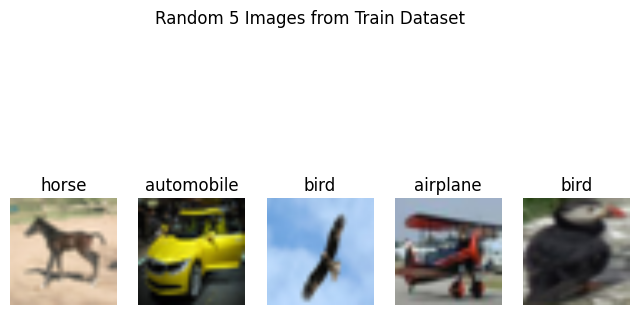

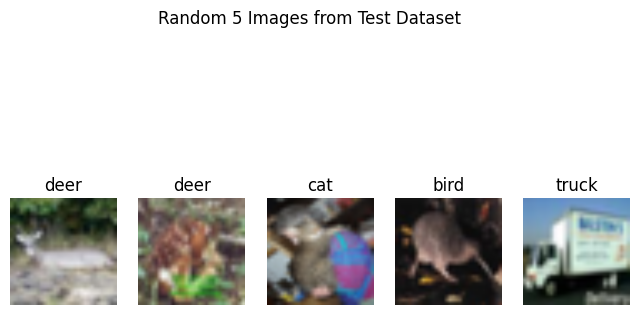

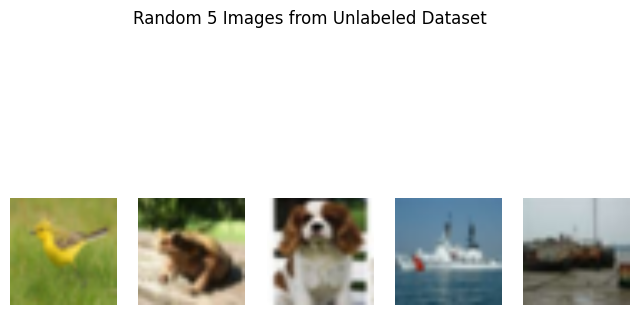

In [7]:
# Define class names for CIFAR-10 dataset
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# Define a function to plot a grid of images
def plot_images(dataset, title):
    plt.figure(figsize=(8, 5))
    indices = np.random.choice(len(dataset), 5, replace=False)
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        plt.subplot(1, 5, i + 1)
        plt.imshow(image)
        plt.title(f"{class_names[label]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Plot random images from train and test datasets
plot_images(train_dataset, "Random 5 Images from Train Dataset")
plot_images(test_dataset, "Random 5 Images from Test Dataset")

# Plot random images from unlabeled dataset
plt.figure(figsize=(8, 5))
indices = np.random.choice(len(unlabeled), 5, replace=False)
for i, idx in enumerate(indices):
    image, _ = unlabeled[idx]
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
plt.suptitle("Random 5 Images from Unlabeled Dataset")
plt.show()


# Augmenting The Dataset

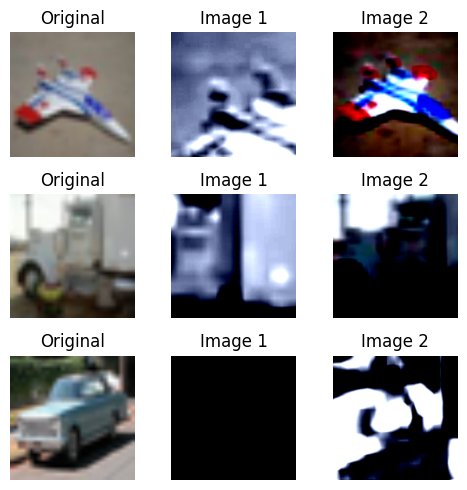

In [8]:
class MyDataset(Dataset):
    def __init__(self, dataset, mutation=False):
        self.dataset = dataset
        self.mutation = mutation

    def __len__(self):
        return len(self.dataset)

    def tensorify(self, img):
        res = T.ToTensor()(img)
        res = T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))(res)
        return res

    # Here, s is the strength of color distortion.
    def get_color_distortion(self,s=1.0):
        color_jitter = T.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
        rnd_color_jitter = T.RandomApply([color_jitter], p=0.8)
        # p is the probability of grayscale, here 0.2
        rnd_gray = T.RandomGrayscale(p=0.2)
        color_distort = T.Compose([rnd_color_jitter, rnd_gray])
        return color_distort

    def mutate_image(self, img):
        res = T.RandomResizedCrop(224)(img)
        res = self.get_color_distortion(1)(res)
        return res

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        if self.mutation:
            image1 = self.mutate_image(img)
            image1 = self.tensorify(image1)
            image2 = self.mutate_image(img)
            image2 = self.tensorify(image2)
            sample = {'image1': image1, 'image2': image2,'label': label}

        else:
            img = T.Resize((224, 224))(img)
            img = self.tensorify(img)
            sample = {'image': img,'label': label}

        return sample


# Create an instance of MyDataset for the unlabeled dataset
transformed_unlabeled_dataset = MyDataset(unlabeled,True)
transformed_train_dataset = MyDataset(train_dataset)
transformed_test_dataset = MyDataset(test_dataset)

#Visualizing Augmented Images
# Create a figure with 3 rows and 3 columns
fig, axes = plt.subplots(3, 3, figsize=(5, 5))

# Flatten the axes array to iterate over each subplot
axes = axes.flatten()

# Iterate over the first 3 samples in the dataset
for i in range(25,28,1):
    # Get the sample from the dataset
    sample = transformed_unlabeled_dataset[i]
    i = i-25
    # Plot the original image
    axes[i * 3].imshow(np.array(unlabeled[i+25][0]))
    axes[i * 3].set_title("Original")
    axes[i * 3].axis('off')

    # Plot image 1
    axes[i * 3 + 1].imshow(sample['image1'].permute(1, 2, 0))
    axes[i * 3 + 1].set_title("Image 1")
    axes[i * 3 + 1].axis('off')

    # Plot image 2
    axes[i * 3 + 2].imshow(sample['image2'].permute(1, 2, 0))  # Transpose
    axes[i * 3 + 2].set_title("Image 2")
    axes[i * 3 + 2].axis('off')

plt.tight_layout()
plt.show()

# SimCLR

In [6]:
class SimCLR(nn.Module):

   #Defined the model inside init method
    def __init__(self, base_model,output_dim):
        super(SimCLR, self).__init__()
        self.resnet_dict = {"resnet18": models.resnet18(pretrained=False, num_classes=256),
                            "resnet50": models.resnet50(pretrained=False, num_classes=256)}
        self.backbone = self.resnet_dict[base_model]

        # add mlp projection head
        self.projection_head = nn.Sequential(nn.Linear(256, 172), nn.ReLU(), nn.Linear(172, output_dim))

    def forward(self, x):
        # Pass input through the backbone
        features = self.backbone(x)
        # Pass features through the projection head
        output = self.projection_head(features)
        return output

    def loss(self,a,b,tau):
        a_norm = torch.norm(a,dim=1).reshape(-1,1)
        a_cap = torch.div(a,a_norm)
        b_norm = torch.norm(b,dim=1).reshape(-1,1)
        b_cap = torch.div(b,b_norm)
        a_cap_b_cap = torch.cat([a_cap,b_cap],dim=0)
        a_cap_b_cap_transpose = torch.t(a_cap_b_cap)
        b_cap_a_cap = torch.cat([b_cap,a_cap],dim=0)
        sim = torch.mm(a_cap_b_cap,a_cap_b_cap_transpose)
        sim_by_tau = torch.div(sim,tau)
        exp_sim_by_tau = torch.exp(sim_by_tau)
        sum_of_rows = torch.sum(exp_sim_by_tau, dim=1)
        exp_sim_by_tau_diag = torch.diag(exp_sim_by_tau)
        numerators = torch.exp(torch.div(torch.nn.CosineSimilarity()(a_cap_b_cap,b_cap_a_cap),tau))
        denominators = sum_of_rows - exp_sim_by_tau_diag
        num_by_den = torch.div(numerators,denominators)
        neglog_num_by_den = -torch.log(num_by_den)
        return torch.mean(neglog_num_by_den)

    def train_simclr(self,model,optimizer,num_epochs,dataset,tau):
        # device is set to cuda if cuda is available
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        losses_train = []
        # get resnet in train mode
        model.to(device)
        model.train()

        # run a for loop for num_epochs
        for epoch in range(num_epochs):
          # a list to store losses for each epoch
          epoch_losses_train = []

          # wrap dataset with tqdm to get a progress bar
          t_dataset = tqdm(dataset, total=len(dataset), desc=f"Epoch {epoch+1}/{num_epochs}")
          # run a for loop for each batch
          for (_, sample_batched) in enumerate(t_dataset):
              # zero out grads
              optimizer.zero_grad()

              # retrieve x1 and x2 the two image batches
              x1 = sample_batched['image1']
              x2 = sample_batched['image2']

              # move them to the device
              x1 = x1.to(device)
              x2 = x2.to(device)

              # get their outputs
              y1 = self.forward(x1)
              y2 = self.forward(x2)

              # get loss value
              loss = self.loss(y1, y2, tau)

              # put that loss value in the epoch losses list
              epoch_losses_train.append(loss.cpu().data.item())

              # perform backprop on loss value to get gradient values
              loss.backward()

              # run the optimizer
              optimizer.step()

              # Update the progress bar with the current loss
              t_dataset.set_postfix(loss=loss.item())

          # append mean of epoch losses to losses_train, essentially this will reflect mean batch loss
          epoch_loss = sum(epoch_losses_train) / len(epoch_losses_train)
          losses_train.append(epoch_loss)
          print(f'Epoch {epoch+1}, Mean Loss: {epoch_loss}')

        # Save the state dictionaries of backbone and projection head separately
        torch.save(simclr_model.backbone.state_dict(), '/kaggle/working/simclr_backbone.pth')
        torch.save(simclr_model.projection_head.state_dict(), '/kaggle/working/simclr_projection_head.pth')
        return losses_train

# Contrastive Pre-training

Epoch 1/100: 100%|██████████| 165/165 [05:18<00:00,  1.93s/it, loss=3.09]


Epoch 1, Mean Loss: 6.060686449571089


Epoch 2/100: 100%|██████████| 165/165 [05:19<00:00,  1.94s/it, loss=3.2] 


Epoch 2, Mean Loss: 5.982402683026863


Epoch 3/100: 100%|██████████| 165/165 [05:18<00:00,  1.93s/it, loss=3.33]


Epoch 3, Mean Loss: 5.953359252756292


Epoch 4/100: 100%|██████████| 165/165 [05:18<00:00,  1.93s/it, loss=3.17]


Epoch 4, Mean Loss: 5.836336742747914


Epoch 5/100: 100%|██████████| 165/165 [05:21<00:00,  1.95s/it, loss=3.2] 


Epoch 5, Mean Loss: 5.720116914402355


Epoch 6/100: 100%|██████████| 165/165 [05:20<00:00,  1.94s/it, loss=2.33]


Epoch 6, Mean Loss: 5.6118045951380875


Epoch 7/100: 100%|██████████| 165/165 [05:17<00:00,  1.92s/it, loss=2.52]


Epoch 7, Mean Loss: 5.411423746744791


Epoch 8/100: 100%|██████████| 165/165 [05:16<00:00,  1.92s/it, loss=2.37]


Epoch 8, Mean Loss: 5.337148545005105


Epoch 9/100: 100%|██████████| 165/165 [05:14<00:00,  1.91s/it, loss=2.29]


Epoch 9, Mean Loss: 5.308348558888291


Epoch 10/100: 100%|██████████| 165/165 [05:17<00:00,  1.92s/it, loss=2.79]


Epoch 10, Mean Loss: 5.273594591834328


Epoch 11/100: 100%|██████████| 165/165 [05:15<00:00,  1.91s/it, loss=2.39]


Epoch 11, Mean Loss: 5.254754267316876


Epoch 12/100: 100%|██████████| 165/165 [05:17<00:00,  1.92s/it, loss=2.44]


Epoch 12, Mean Loss: 5.2388952428644355


Epoch 13/100: 100%|██████████| 165/165 [05:16<00:00,  1.92s/it, loss=2.75]


Epoch 13, Mean Loss: 5.217570855400779


Epoch 14/100: 100%|██████████| 165/165 [05:20<00:00,  1.94s/it, loss=2.28]


Epoch 14, Mean Loss: 5.197885224313447


Epoch 15/100: 100%|██████████| 165/165 [05:16<00:00,  1.92s/it, loss=2.62]


Epoch 15, Mean Loss: 5.172490953676628


Epoch 16/100: 100%|██████████| 165/165 [05:15<00:00,  1.91s/it, loss=2.36]


Epoch 16, Mean Loss: 5.156309023770419


Epoch 17/100: 100%|██████████| 165/165 [05:15<00:00,  1.91s/it, loss=2.25]


Epoch 17, Mean Loss: 5.126853533947107


Epoch 18/100: 100%|██████████| 165/165 [05:15<00:00,  1.91s/it, loss=2.58]


Epoch 18, Mean Loss: 5.105844960068211


Epoch 19/100: 100%|██████████| 165/165 [05:17<00:00,  1.92s/it, loss=2.24]


Epoch 19, Mean Loss: 5.097429087667754


Epoch 20/100: 100%|██████████| 165/165 [05:15<00:00,  1.91s/it, loss=2.34]


Epoch 20, Mean Loss: 5.0822090553514885


Epoch 21/100: 100%|██████████| 165/165 [05:17<00:00,  1.92s/it, loss=2.53]


Epoch 21, Mean Loss: 5.073116774992509


Epoch 22/100: 100%|██████████| 165/165 [05:17<00:00,  1.92s/it, loss=2.24]


Epoch 22, Mean Loss: 5.066754060803038


Epoch 23/100: 100%|██████████| 165/165 [05:15<00:00,  1.91s/it, loss=2.41]


Epoch 23, Mean Loss: 5.056198914845784


Epoch 24/100: 100%|██████████| 165/165 [05:17<00:00,  1.92s/it, loss=2.21]


Epoch 24, Mean Loss: 5.045976543426514


Epoch 25/100: 100%|██████████| 165/165 [05:17<00:00,  1.92s/it, loss=2.18]


Epoch 25, Mean Loss: 5.036269635865183


Epoch 26/100: 100%|██████████| 165/165 [05:17<00:00,  1.93s/it, loss=2.28]


Epoch 26, Mean Loss: 5.020336109219175


Epoch 27/100: 100%|██████████| 165/165 [05:15<00:00,  1.91s/it, loss=2.01]


Epoch 27, Mean Loss: 5.013365560589414


Epoch 28/100: 100%|██████████| 165/165 [05:14<00:00,  1.91s/it, loss=2.36]


Epoch 28, Mean Loss: 4.999252825072317


Epoch 29/100: 100%|██████████| 165/165 [05:14<00:00,  1.90s/it, loss=2.3] 


Epoch 29, Mean Loss: 4.998461857709017


Epoch 30/100: 100%|██████████| 165/165 [05:14<00:00,  1.91s/it, loss=2.15]


Epoch 30, Mean Loss: 4.988667337822192


Epoch 31/100: 100%|██████████| 165/165 [05:14<00:00,  1.91s/it, loss=2.19]


Epoch 31, Mean Loss: 4.990602189844305


Epoch 32/100: 100%|██████████| 165/165 [05:15<00:00,  1.91s/it, loss=2.32]


Epoch 32, Mean Loss: 4.982808461333766


Epoch 33/100: 100%|██████████| 165/165 [05:17<00:00,  1.92s/it, loss=2.21]


Epoch 33, Mean Loss: 4.976041711460461


Epoch 34/100: 100%|██████████| 165/165 [05:16<00:00,  1.92s/it, loss=2.2] 


Epoch 34, Mean Loss: 4.970793698050759


Epoch 35/100: 100%|██████████| 165/165 [05:22<00:00,  1.95s/it, loss=2.2] 


Epoch 35, Mean Loss: 4.970559293573553


Epoch 36/100: 100%|██████████| 165/165 [05:23<00:00,  1.96s/it, loss=2.19]


Epoch 36, Mean Loss: 4.970384513970577


Epoch 37/100: 100%|██████████| 165/165 [05:22<00:00,  1.95s/it, loss=2.06]


Epoch 37, Mean Loss: 4.963889555497603


Epoch 38/100: 100%|██████████| 165/165 [05:17<00:00,  1.93s/it, loss=2.33]


Epoch 38, Mean Loss: 4.958257175214363


Epoch 39/100: 100%|██████████| 165/165 [05:17<00:00,  1.93s/it, loss=2.16]


Epoch 39, Mean Loss: 4.955561058449023


Epoch 40/100: 100%|██████████| 165/165 [05:15<00:00,  1.91s/it, loss=2.04]


Epoch 40, Mean Loss: 4.949731789213239


Epoch 41/100: 100%|██████████| 165/165 [05:19<00:00,  1.94s/it, loss=2.16]


Epoch 41, Mean Loss: 4.946183201760957


Epoch 42/100: 100%|██████████| 165/165 [05:23<00:00,  1.96s/it, loss=2.45]


Epoch 42, Mean Loss: 4.947425244071267


Epoch 43/100: 100%|██████████| 165/165 [05:18<00:00,  1.93s/it, loss=2.23]


Epoch 43, Mean Loss: 4.947717169559363


Epoch 44/100: 100%|██████████| 165/165 [05:18<00:00,  1.93s/it, loss=2.13]


Epoch 44, Mean Loss: 4.94097013762503


Epoch 45/100: 100%|██████████| 165/165 [05:22<00:00,  1.96s/it, loss=2.27]


Epoch 45, Mean Loss: 4.936564392032046


Epoch 46/100: 100%|██████████| 165/165 [05:22<00:00,  1.96s/it, loss=2.22]


Epoch 46, Mean Loss: 4.944461313883464


Epoch 47/100: 100%|██████████| 165/165 [05:25<00:00,  1.98s/it, loss=2.02]


Epoch 47, Mean Loss: 4.9327618772333315


Epoch 48/100: 100%|██████████| 165/165 [05:25<00:00,  1.97s/it, loss=2.16]


Epoch 48, Mean Loss: 4.929399805357962


Epoch 49/100: 100%|██████████| 165/165 [05:21<00:00,  1.95s/it, loss=2.06]


Epoch 49, Mean Loss: 4.932201035817465


Epoch 50/100: 100%|██████████| 165/165 [05:21<00:00,  1.95s/it, loss=2.15]


Epoch 50, Mean Loss: 4.926719575939757


Epoch 51/100: 100%|██████████| 165/165 [05:18<00:00,  1.93s/it, loss=2.12]


Epoch 51, Mean Loss: 4.9281707098989775


Epoch 52/100: 100%|██████████| 165/165 [05:24<00:00,  1.97s/it, loss=2.08]


Epoch 52, Mean Loss: 4.923028029817523


Epoch 53/100: 100%|██████████| 165/165 [05:22<00:00,  1.95s/it, loss=2.09]


Epoch 53, Mean Loss: 4.92765459580855


Epoch 54/100: 100%|██████████| 165/165 [05:24<00:00,  1.96s/it, loss=2.38]


Epoch 54, Mean Loss: 4.926893338290128


Epoch 55/100: 100%|██████████| 165/165 [05:38<00:00,  2.05s/it, loss=2.05]


Epoch 55, Mean Loss: 4.918898163419781


Epoch 56/100: 100%|██████████| 165/165 [05:55<00:00,  2.16s/it, loss=2.15]


Epoch 56, Mean Loss: 4.91883524981412


Epoch 57/100: 100%|██████████| 165/165 [06:09<00:00,  2.24s/it, loss=2.25]


Epoch 57, Mean Loss: 4.918316702409224


Epoch 58/100: 100%|██████████| 165/165 [06:05<00:00,  2.21s/it, loss=2.09]


Epoch 58, Mean Loss: 4.922203153552431


Epoch 59/100: 100%|██████████| 165/165 [06:01<00:00,  2.19s/it, loss=1.99]


Epoch 59, Mean Loss: 4.9145987373409845


Epoch 60/100: 100%|██████████| 165/165 [06:05<00:00,  2.22s/it, loss=2.07]


Epoch 60, Mean Loss: 4.911746897841945


Epoch 61/100: 100%|██████████| 165/165 [06:10<00:00,  2.25s/it, loss=2.01]


Epoch 61, Mean Loss: 4.911817224097974


Epoch 62/100: 100%|██████████| 165/165 [06:11<00:00,  2.25s/it, loss=2.15]


Epoch 62, Mean Loss: 4.906221970644864


Epoch 63/100: 100%|██████████| 165/165 [06:09<00:00,  2.24s/it, loss=2.13]


Epoch 63, Mean Loss: 4.910214019544197


Epoch 64/100: 100%|██████████| 165/165 [06:06<00:00,  2.22s/it, loss=2.04]


Epoch 64, Mean Loss: 4.90974946455522


Epoch 65/100: 100%|██████████| 165/165 [06:11<00:00,  2.25s/it, loss=2.12]


Epoch 65, Mean Loss: 4.906369428923636


Epoch 66/100: 100%|██████████| 165/165 [06:09<00:00,  2.24s/it, loss=2.19]


Epoch 66, Mean Loss: 4.908146187753388


Epoch 67/100: 100%|██████████| 165/165 [06:08<00:00,  2.23s/it, loss=2.27]


Epoch 67, Mean Loss: 4.9078033505064065


Epoch 68/100: 100%|██████████| 165/165 [06:05<00:00,  2.21s/it, loss=2.03]


Epoch 68, Mean Loss: 4.906609104618882


Epoch 69/100: 100%|██████████| 165/165 [06:05<00:00,  2.22s/it, loss=2.37]


Epoch 69, Mean Loss: 4.902773595578743


Epoch 70/100: 100%|██████████| 165/165 [06:06<00:00,  2.22s/it, loss=2.05]


Epoch 70, Mean Loss: 4.905740411353833


Epoch 71/100: 100%|██████████| 165/165 [06:02<00:00,  2.20s/it, loss=1.97]


Epoch 71, Mean Loss: 4.903637300838124


Epoch 72/100: 100%|██████████| 165/165 [06:06<00:00,  2.22s/it, loss=1.96]


Epoch 72, Mean Loss: 4.900219235275731


Epoch 73/100: 100%|██████████| 165/165 [06:09<00:00,  2.24s/it, loss=2.2] 


Epoch 73, Mean Loss: 4.900749326474739


Epoch 74/100: 100%|██████████| 165/165 [06:12<00:00,  2.26s/it, loss=2.09]


Epoch 74, Mean Loss: 4.90063805435643


Epoch 75/100: 100%|██████████| 165/165 [06:11<00:00,  2.25s/it, loss=2.07]


Epoch 75, Mean Loss: 4.899974265243068


Epoch 76/100: 100%|██████████| 165/165 [06:10<00:00,  2.25s/it, loss=2.05]


Epoch 76, Mean Loss: 4.8991668816768765


Epoch 77/100: 100%|██████████| 165/165 [06:09<00:00,  2.24s/it, loss=2.24]


Epoch 77, Mean Loss: 4.899876201514042


Epoch 78/100: 100%|██████████| 165/165 [06:07<00:00,  2.23s/it, loss=2.09]


Epoch 78, Mean Loss: 4.9038289994904485


Epoch 79/100: 100%|██████████| 165/165 [06:09<00:00,  2.24s/it, loss=1.99]


Epoch 79, Mean Loss: 4.898699834130027


Epoch 80/100: 100%|██████████| 165/165 [06:09<00:00,  2.24s/it, loss=2.23]


Epoch 80, Mean Loss: 4.9034409147320375


Epoch 81/100: 100%|██████████| 165/165 [06:14<00:00,  2.27s/it, loss=2.15]


Epoch 81, Mean Loss: 4.899108967636571


Epoch 82/100: 100%|██████████| 165/165 [06:11<00:00,  2.25s/it, loss=2.23]


Epoch 82, Mean Loss: 4.897715535308375


Epoch 83/100: 100%|██████████| 165/165 [06:12<00:00,  2.26s/it, loss=2.23]


Epoch 83, Mean Loss: 4.901760411984993


Epoch 84/100: 100%|██████████| 165/165 [06:13<00:00,  2.26s/it, loss=2.03]


Epoch 84, Mean Loss: 4.892307714982466


Epoch 85/100: 100%|██████████| 165/165 [06:16<00:00,  2.28s/it, loss=2.2] 


Epoch 85, Mean Loss: 4.896701022350427


Epoch 86/100: 100%|██████████| 165/165 [06:12<00:00,  2.26s/it, loss=2.01]


Epoch 86, Mean Loss: 4.897231710318363


Epoch 87/100: 100%|██████████| 165/165 [06:13<00:00,  2.26s/it, loss=2.04]


Epoch 87, Mean Loss: 4.890561421712239


Epoch 88/100: 100%|██████████| 165/165 [06:13<00:00,  2.26s/it, loss=2.17]


Epoch 88, Mean Loss: 4.891128713434393


Epoch 89/100: 100%|██████████| 165/165 [06:09<00:00,  2.24s/it, loss=2.07]


Epoch 89, Mean Loss: 4.893437813267563


Epoch 90/100: 100%|██████████| 165/165 [06:10<00:00,  2.25s/it, loss=2.1] 


Epoch 90, Mean Loss: 4.896647555900342


Epoch 91/100: 100%|██████████| 165/165 [06:05<00:00,  2.22s/it, loss=2.27]


Epoch 91, Mean Loss: 4.897229029915549


Epoch 92/100: 100%|██████████| 165/165 [06:09<00:00,  2.24s/it, loss=2.33]


Epoch 92, Mean Loss: 4.89310181646636


Epoch 93/100: 100%|██████████| 165/165 [06:08<00:00,  2.23s/it, loss=1.95]


Epoch 93, Mean Loss: 4.898868547786366


Epoch 94/100: 100%|██████████| 165/165 [06:08<00:00,  2.23s/it, loss=2.07]


Epoch 94, Mean Loss: 4.891695781187578


Epoch 95/100: 100%|██████████| 165/165 [06:10<00:00,  2.24s/it, loss=2.01]


Epoch 95, Mean Loss: 4.885722960847797


Epoch 96/100: 100%|██████████| 165/165 [06:10<00:00,  2.25s/it, loss=2.06]


Epoch 96, Mean Loss: 4.887781114289255


Epoch 97/100: 100%|██████████| 165/165 [06:05<00:00,  2.22s/it, loss=2.23]


Epoch 97, Mean Loss: 4.89032655918237


Epoch 98/100: 100%|██████████| 165/165 [06:11<00:00,  2.25s/it, loss=2.1] 


Epoch 98, Mean Loss: 4.885937514449611


Epoch 99/100: 100%|██████████| 165/165 [06:13<00:00,  2.26s/it, loss=2.37]


Epoch 99, Mean Loss: 4.891857421759403


Epoch 100/100: 100%|██████████| 165/165 [06:12<00:00,  2.26s/it, loss=2.05]


Epoch 100, Mean Loss: 4.8861675811536385


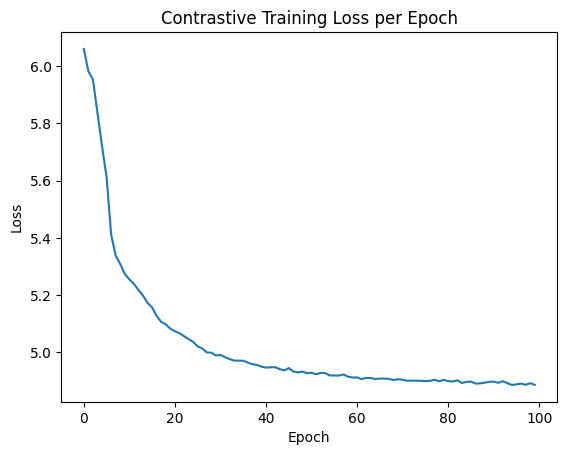

CPU times: user 3h 34min 33s, sys: 26min 48s, total: 4h 1min 22s
Wall time: 9h 29min 16s


In [7]:
%%time
# Initialize the model
base_model = "resnet18"  # or "resnet50"
output_dim = 128  # output dimension of projection_head
simclr_model = SimCLR(base_model,output_dim)
# Initialize optimizer
optimizer = optim.Adam(simclr_model.parameters(), lr=0.003, weight_decay=1e-4)

# dataloaders
contrastive_pretraining_dataset = DataLoader(transformed_unlabeled_dataset, batch_size=256, shuffle=True, num_workers=2)
finetuning_dataset = DataLoader(transformed_train_dataset, batch_size=256, shuffle=True, num_workers=2)
test_dataset = DataLoader(transformed_test_dataset, batch_size=256, shuffle=True, num_workers=2)

# Define number of epochs
num_epochs = 100
losses_train = simclr_model.train_simclr(simclr_model,optimizer,num_epochs,contrastive_pretraining_dataset,tau=0.5)

#plotting the loss per epoch
plt.plot(losses_train, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Contrastive Training Loss per Epoch')
fname = f"Contrastive Training Loss per Epoch.png"
plt.savefig(fname)
plt.show()

# Loading the Pretrained Model and Throwing Out the Projection Head

In [10]:
# Instantiate the SimCLR model with the same architecture as before
simclr_model = SimCLR(base_model='resnet18', output_dim=128)  # Adjust parameters as needed

# Load the saved model without the projection head
saved_model_path = '/kaggle/working/simclr_backbone.pth'
state_dict = torch.load(saved_model_path)

# Load the state dictionary into the model
simclr_model.backbone.load_state_dict(state_dict)
# Print the model architecture
print(simclr_model.backbone)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
simclr_model.backbone.to(device)
simclr_model.backbone.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# T-SNE Visualization

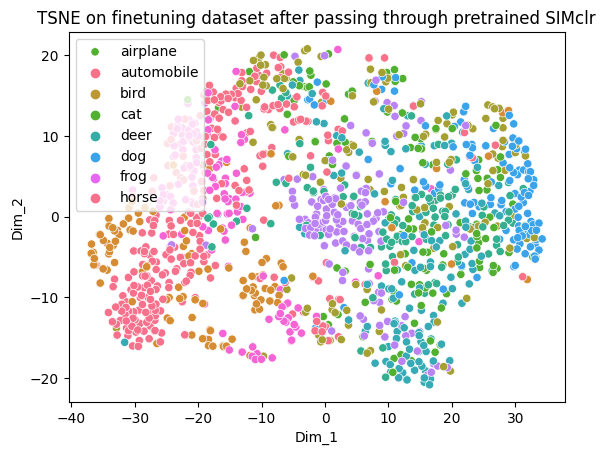

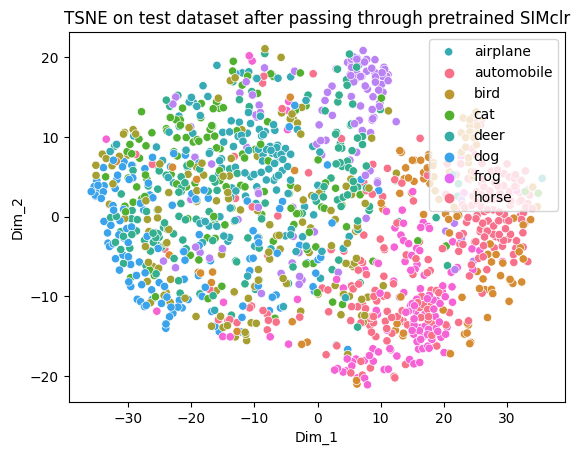

CPU times: user 35.4 s, sys: 3.25 s, total: 38.6 s
Wall time: 39.2 s


In [13]:
%%time

tsne = TSNE(n_components=2, perplexity=50,random_state=42)     
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data = []
labels = []
c = 0
# Loop through batches
for batch in finetuning_dataset:
    if c!=5:
      inputs = batch['image'].to(device)
      outputs = simclr_model.backbone(inputs)  # Adjusting input shape for model inference
      batch_data, batch_labels = outputs.detach().cpu().numpy(), batch['label']
      data.extend(batch_data)
      labels.extend(batch_labels)
      c = c+1
data = np.array(data)

y_tsne = tsne.fit_transform(data)
fname = f"tsne_finetuning_dataset.png"  # Adjusted file name
tsne_data = np.vstack((y_tsne.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
sns.scatterplot(x="Dim_1", y="Dim_2", hue="label", data=tsne_df,palette="husl")
# Manually set the legend labels
plt.legend(labels=class_names)
plt.title('TSNE on finetuning dataset after passing through pretrained SIMclr')
plt.savefig(fname)
plt.show()


data = []
labels = []
c = 0
# Loop through batches
for batch in test_dataset:
    if c!=5:
      inputs = batch['image'].to(device)
      outputs = simclr_model.backbone(inputs)  # Adjusting input shape for model inference
      batch_data, batch_labels = outputs.detach().cpu().numpy(), batch['label']
      data.extend(batch_data)
      labels.extend(batch_labels)
      c = c+1
data = np.array(data)

y_tsne = tsne.fit_transform(data)
fname = f"tsne_test_dataset.png"  # Adjusted file name
tsne_data = np.vstack((y_tsne.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
sns.scatterplot(x="Dim_1", y="Dim_2", hue="label", data=tsne_df,palette="husl")
# Manually set the legend labels
plt.legend(labels=class_names)
plt.title('TSNE on test dataset after passing through pretrained SIMclr')
plt.savefig(fname)
plt.show()

# Supervised Finetuning Of SIMclr

**Defining The Model for Finetuning**

In [14]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        # Define layers
        self.fc1 = nn.Linear(256, 128)  
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)  
        self.relu = nn.ReLU()   
        
    def forward(self, x):
        # Forward pass
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Create an instance of the neural network
model = NeuralNetwork()

# Print the model architecture
print(model)

NeuralNetwork(
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
)


**Finetuning**

Epoch 1/20: 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]


Epoch [1/20], Training Loss: 2.2542, Training Accuracy: 22.52%, Validation Loss: 2.1506, Validation Accuracy: 47.60%


Epoch 2/20: 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]


Epoch [2/20], Training Loss: 1.9622, Training Accuracy: 43.15%, Validation Loss: 1.6805, Validation Accuracy: 48.13%


Epoch 3/20: 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]


Epoch [3/20], Training Loss: 1.5071, Training Accuracy: 51.09%, Validation Loss: 1.3241, Validation Accuracy: 54.87%


Epoch 4/20: 100%|██████████| 6/6 [00:02<00:00,  2.16it/s]


Epoch [4/20], Training Loss: 1.2839, Training Accuracy: 54.68%, Validation Loss: 1.2018, Validation Accuracy: 56.67%


Epoch 5/20: 100%|██████████| 6/6 [00:02<00:00,  2.43it/s]


Epoch [5/20], Training Loss: 1.2046, Training Accuracy: 56.26%, Validation Loss: 1.1480, Validation Accuracy: 58.40%


Epoch 6/20: 100%|██████████| 6/6 [00:02<00:00,  2.59it/s]


Epoch [6/20], Training Loss: 1.1624, Training Accuracy: 57.49%, Validation Loss: 1.1228, Validation Accuracy: 58.67%


Epoch 7/20: 100%|██████████| 6/6 [00:02<00:00,  2.37it/s]


Epoch [7/20], Training Loss: 1.1319, Training Accuracy: 58.82%, Validation Loss: 1.0970, Validation Accuracy: 59.87%


Epoch 8/20: 100%|██████████| 6/6 [00:02<00:00,  2.44it/s]


Epoch [8/20], Training Loss: 1.1118, Training Accuracy: 59.45%, Validation Loss: 1.0800, Validation Accuracy: 61.53%


Epoch 9/20: 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]


Epoch [9/20], Training Loss: 1.0997, Training Accuracy: 60.15%, Validation Loss: 1.0685, Validation Accuracy: 61.20%


Epoch 10/20: 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]


Epoch [10/20], Training Loss: 1.0867, Training Accuracy: 60.28%, Validation Loss: 1.0663, Validation Accuracy: 61.13%


Epoch 11/20: 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]


Epoch [11/20], Training Loss: 1.0771, Training Accuracy: 60.54%, Validation Loss: 1.0566, Validation Accuracy: 62.47%


Epoch 12/20: 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]


Epoch [12/20], Training Loss: 1.0685, Training Accuracy: 61.14%, Validation Loss: 1.0477, Validation Accuracy: 62.00%


Epoch 13/20: 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]


Epoch [13/20], Training Loss: 1.0706, Training Accuracy: 61.49%, Validation Loss: 1.0503, Validation Accuracy: 62.00%


Epoch 14/20: 100%|██████████| 6/6 [00:02<00:00,  2.36it/s]


Epoch [14/20], Training Loss: 1.0606, Training Accuracy: 61.55%, Validation Loss: 1.0412, Validation Accuracy: 61.93%


Epoch 15/20: 100%|██████████| 6/6 [00:02<00:00,  2.16it/s]


Epoch [15/20], Training Loss: 1.0538, Training Accuracy: 61.54%, Validation Loss: 1.0336, Validation Accuracy: 62.47%


Epoch 16/20: 100%|██████████| 6/6 [00:02<00:00,  2.50it/s]


Epoch [16/20], Training Loss: 1.0467, Training Accuracy: 61.72%, Validation Loss: 1.0369, Validation Accuracy: 62.07%


Epoch 17/20: 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]


Epoch [17/20], Training Loss: 1.0475, Training Accuracy: 61.97%, Validation Loss: 1.0344, Validation Accuracy: 62.27%
Early stopping triggered.


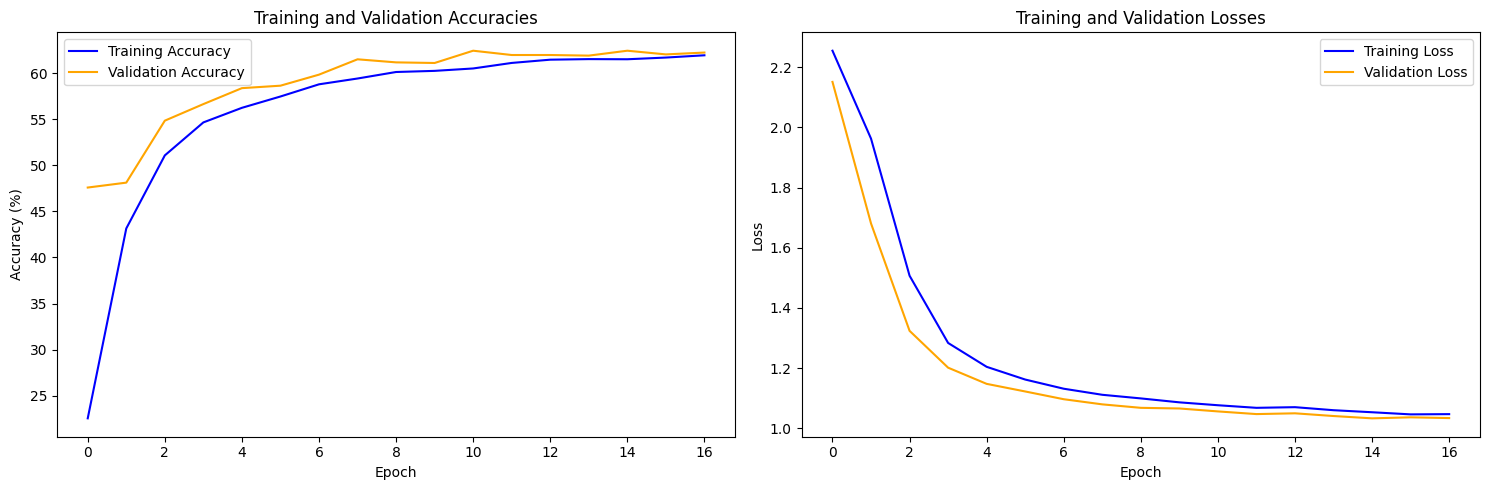

CPU times: user 3min, sys: 27.8 s, total: 3min 28s
Wall time: 4min 7s


In [15]:
%%time
#Finetuning
# Set the random seed
torch.manual_seed(42) 
# Split dataset into train and validation sets
# Define the sizes for train and validation datasets
train_size = 6500
val_size = 1500

# Split the dataset
train_dataset, val_dataset = random_split(transformed_train_dataset, [train_size, val_size])
train_dataset = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2)
val_dataset = DataLoader(val_dataset, batch_size=256, shuffle=True, num_workers=2)


# Initialize model
model = NeuralNetwork()
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Number of epochs
num_epochs = 20

# Lists to store loss and accuracy values for plotting later
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

# Initialize early stopping parameters
best_val_loss = float('inf')
patience = 3
counter = 0

# Train loop
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    # wrap dataset with tqdm to get a progress bar
    t_dataset = tqdm(train_dataset, total=len(train_dataset), desc=f"Epoch {epoch+1}/{num_epochs}")
    # run a for loop for each batch
    for (_, batch) in enumerate(t_dataset):
        images = batch['image'].to(device)  
        labels = batch['label'].to(device) 
        optimizer.zero_grad()
        # Pass each datapoint through simclr.backbone
        features = simclr_model.backbone(images)
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    epoch_train_loss = train_loss / len(train_dataset)
    epoch_train_accuracy = 100 * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    v_dataset = tqdm(val_dataset, total=len(val_dataset), desc=f"Epoch {epoch+1}/{num_epochs}")
    with torch.no_grad():
        for (_, batch) in enumerate(v_dataset):
            images = batch['image'].to(device)  
            labels = batch['label'].to(device)  
            # Pass each datapoint through simclr.backbone
            features = simclr_model.backbone(images)
            outputs = model(features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_accuracy = 100 * correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_accuracy:.2f}%, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.2f}%')

    # Early stopping
    if best_val_loss-epoch_val_loss >.01:
        best_val_loss = epoch_val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Save the trained model
torch.save(model.state_dict(), '/kaggle/working/finetuned_model.pth')

# Visualization Of Metrics
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot training and validation accuracies
axs[0].plot(train_accuracies, label='Training Accuracy', color='blue')
axs[0].plot(val_accuracies, label='Validation Accuracy', color='orange')
axs[0].set_title('Training and Validation Accuracies')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy (%)')
axs[0].legend()

# Plot training and validation losses
axs[1].plot(train_losses, label='Training Loss', color='blue')
axs[1].plot(val_losses, label='Validation Loss', color='orange')
axs[1].set_title('Training and Validation Losses')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

# Adjust layout
plt.tight_layout()

# Save the plot as an image
plt.savefig('/kaggle/working/training_validation_metrics_finetuning_simclr.png')

# Show plot
plt.show()


# Testing

100%|██████████| 40/40 [00:12<00:00,  3.10it/s]


Accuracy: 0.6137
F1 Score: 0.6122679406943717


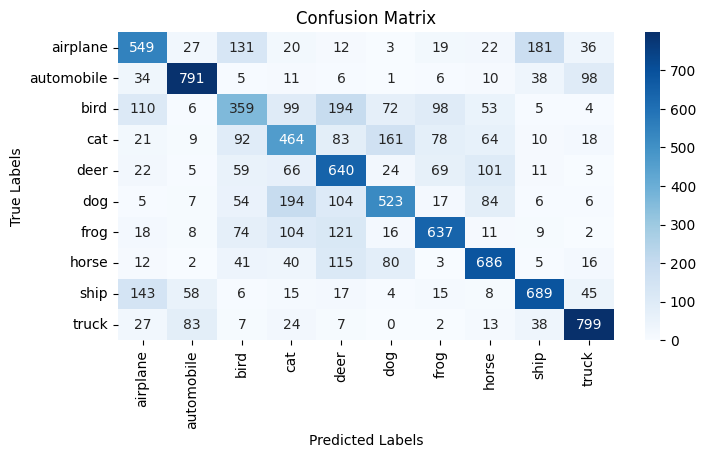

In [17]:
test_dataset = DataLoader(transformed_test_dataset, batch_size=256, shuffle=True, num_workers=2)
# Define lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

model = NeuralNetwork()
model_path = '/kaggle/working/finetuned_model.pth'
model.load_state_dict(torch.load(model_path))
# Set the model to evaluation mode
model.to(device)
model.eval()

t_dataset = tqdm(test_dataset, total=len(test_dataset))
# Iterate through the test dataset and make predictions
with torch.no_grad():
  for (_, batch) in enumerate(t_dataset):
      images = batch['image'].to(device)  
      labels = batch['label'].to(device)
      features = simclr_model.backbone(images)
      outputs = model(features)
      _, predicted = torch.max(outputs, 1)
      true_labels.extend(labels.detach().cpu().numpy())
      predicted_labels.extend(predicted.detach().cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("F1 Score:", f1)

# Plot the confusion matrix
plt.figure(figsize=(8, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('/kaggle/working/SIMclr_confusion_matrix.png')
plt.show()
